# Algorithm Comparison for Behavioral Cloning

This notebook provides a comparison of different neural network architectures for behavioral cloning in the risky navigation environment.

**Algorithms Evaluated:**
- **Linear**: Simple linear regression baseline
- **AutoEncoder**: Neural network encoder-decoder architecture  
- **Bayesian**: Bayesian neural network with uncertainty quantification
- **Transformer**: Self-attention based model
- **VAE**: Variational AutoEncoder with probabilistic latent representations

**Workflow:**
1. **Data Collection**: Load expert demonstrations from optimal visibility graph policy
2. **Model Training**: Train each algorithm with simple, transparent training loop
3. **Evaluation**: Test models in environment and compare performance
4. **Analysis**: Visualize results and compare metrics

This simplified approach prioritizes debuggability and clarity over automated hyperparameter optimization.

## Import Required Libraries

In [58]:
!pip install pandas matplotlib seaborn scikit-learn torch torchvision torchaudio gymnasium tqdm

In [59]:
#  if on runpod
!rm -rf risky_navigation
!git clone https://github.com/mosmith3asu/risky_navigation.git
!cd risky_navigation

Cloning into 'risky_navigation'...
remote: Enumerating objects: 653, done.
remote: Enumerating objects: 653, done.K
remote: Counting objects: 100% (261/261), done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (168/168), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 653 (delta 147), reused 195 (delta 90), pack-reused 392 (from 1)
Receiving objects: 100% (653/653), 19.34 MiB | 35.12 MiB/s, done.
remote: Total 653 (delta 147), reused 195 (delta 90), pack-reused 392 (from 1)
Receiving objects: 100% (653/653), 19.34 MiB | 35.12 MiB/s, done.
Resolving deltas: 100% (327/327), done.
Resolving deltas: 100% (327/327), done.


In [60]:
# Restart the kernel to reload updated modules
import importlib
import sys

# Clear the module cache for AutoEncoder
modules_to_reload = [
    'src.algorithms.AutoEncoder.agent',
    'src.algorithms.Bayesian.agent', 
    'src.algorithms.Transformer.agent',
    'src.algorithms.Linear.agent',
    'src.algorithms.VAE.agent'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import time
import os
import warnings
from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import ParameterGrid
import random
from itertools import product

# print current path
print(os.path.abspath('.'))

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')



/


In [ ]:
# Import environment and algorithms
import sys
sys.path.append('/risky_navigation')

from src.env.continuous_nav_env import ContinuousNavigationEnv
from src.algorithms.AutoEncoder.agent import AutoEncoderAgent
from src.algorithms.Bayesian.agent import BayesianAgent
from src.algorithms.Transformer.agent import TransformerAgent
from src.algorithms.Linear.agent import LinearAgent
from src.algorithms.VAE.agent import VAEAgent
from src.utils.file_management import save_pickle, load_pickle
from src.utils.logger import Logger

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

# Test AutoEncoder architecture to verify fix (state_dim=8 for full state)
print("\nTesting AutoEncoder architecture:")
test_model = AutoEncoderAgent(state_dim=8, action_dim=2, 
                             latent_dim=32, hidden_dims=[128, 64])
print("AutoEncoder architecture verification successful!")
print("✓ Using state-only approach (8D state, no separate goal)")


All libraries imported successfully!
PyTorch version: 2.8.0+cu128
Device available: CUDA

Testing AutoEncoder architecture:
AutoEncoder architecture verification successful!


## Config

In [62]:
# Simplified Configuration
CONFIG = {
    'num_episodes': 1000,          # Episodes for data collection
    'max_steps': 200,             # Max steps per episode
    'batch_size': 256,            # Batch size
    'num_epochs': 100,            # Training epochs
    'val_ratio': 0.2,             # Validation set ratio
    'num_test_episodes': 50,      # Episodes for testing
    'lr': 1e-3,                   # Learning rate
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
}

# Model-specific hyperparameters (manually chosen)
MODEL_CONFIGS = {
    'AutoEncoder': {'latent_dim': 32, 'hidden_dims': [128, 64]},
    'Linear': {},  # No special hyperparameters
    'Transformer': {'d_model': 64, 'nhead': 4, 'num_layers': 2, 'dropout': 0.1},
    'Bayesian': {'hidden_dim': 128, 'prior_std': 1.0},
    'VAE': {'latent_dim': 32, 'hidden_dim': 128, 'beta': 1.0}
}

print(f"Using device: {CONFIG['device']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Training epochs: {CONFIG['num_epochs']}")

Using device: cuda
Batch size: 256
Training epochs: 100


In [63]:
# Add this cell RIGHT AFTER the "Config" section (after the CONFIG dictionary cell)

# ============================================================
# GPU OPTIMIZATION SETTINGS FOR RTX 4090
# ============================================================

if torch.cuda.is_available():
    print("\n" + "="*60)
    print("CONFIGURING GPU OPTIMIZATIONS FOR RTX 4090")
    print("="*60)
    
    # Enable cuDNN auto-tuner for optimal convolution algorithms
    torch.backends.cudnn.benchmark = True
    print("✓ cuDNN benchmark mode enabled")
    
    # Use TensorFloat32 (TF32) for faster matrix multiplication on Ampere GPUs
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    print("✓ TF32 enabled for matrix operations")
    
    # Set matmul precision for better performance
    torch.set_float32_matmul_precision('high')
    print("✓ Float32 matmul precision set to 'high'")
    
    # Enable memory efficient attention if available
    try:
        torch.backends.cuda.enable_mem_efficient_sdp(True)
        print("✓ Memory efficient scaled dot product enabled")
    except:
        print("⚠ Memory efficient SDP not available (PyTorch < 2.0)")
    
    # Pre-allocate GPU memory for better performance
    torch.cuda.empty_cache()
    print("✓ GPU cache cleared")
    
    print("="*60 + "\n")
    
else:
    print("WARNING: CUDA not available. Running on CPU will be very slow!")

# ============================================================
# UPDATE CONFIG WITH OPTIMIZED BATCH SIZE FOR RTX 4090
# ============================================================

# Update batch size to maximize GPU utilization
CONFIG['batch_size'] = 256  # Increased from 128 to utilize RTX 4090's 24GB VRAM

print(f"\n✓ Batch size optimized for RTX 4090: {CONFIG['batch_size']}")
print(f"✓ Expected GPU memory usage: ~8-12GB out of 24GB available")
print(f"✓ This should increase GPU utilization from 20% to 80-95%\n")


CONFIGURING GPU OPTIMIZATIONS FOR RTX 4090
✓ cuDNN benchmark mode enabled
✓ TF32 enabled for matrix operations
✓ Float32 matmul precision set to 'high'
✓ Memory efficient scaled dot product enabled
✓ GPU cache cleared


✓ Batch size optimized for RTX 4090: 256
✓ Expected GPU memory usage: ~8-12GB out of 24GB available
✓ This should increase GPU utilization from 20% to 80-95%



## Training Function

In [64]:
# Simplified Training Function (No Hyperparameter Search)
# FIXED: Use state-only (goal info is already in state dimensions 4-5)

def train_agent_simple(agent, train_states, train_expert_actions, train_goals,
                       val_states, val_expert_actions, val_goals, 
                       num_epochs=100, batch_size=256, device='cpu', verbose=True):
    """
    Simple training loop with validation tracking.
    FIXED: Uses state-only as input (goal info already in state[4:6])
    
    Args:
        agent: Agent instance with train_step method
        train/val data: Numpy arrays of states, actions, goals (goals kept for compatibility)
        num_epochs: Number of training epochs
        batch_size: Batch size for training
        device: torch device
        verbose: Print progress
    
    Returns:
        train_losses, val_losses: Lists of losses per epoch
    """
    train_losses = []
    val_losses = []
    
    n_train = len(train_states)
    
    for epoch in range(num_epochs):
        # Training
        epoch_loss = 0.0
        num_batches = 0
        
        # Shuffle training data
        indices = np.random.permutation(n_train)
        
        for start_idx in range(0, n_train, batch_size):
            end_idx = min(start_idx + batch_size, n_train)
            batch_indices = indices[start_idx:end_idx]
            
            # Convert to tensors - STATE ONLY (no goal concatenation)
            batch_states = torch.tensor(train_states[batch_indices], dtype=torch.float32, device=device)
            batch_actions = torch.tensor(train_expert_actions[batch_indices], dtype=torch.float32, device=device)
            
            # Train step (behavioral cloning: state -> expert_action)
            # Pass None for actions and goals (not used in state-only mode)
            loss = agent.train_step(batch_states, None, None, batch_actions)
            
            epoch_loss += loss
            num_batches += 1
        
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation - STATE ONLY
        val_states_t = torch.tensor(val_states, dtype=torch.float32, device=device)
        val_actions_t = torch.tensor(val_expert_actions, dtype=torch.float32, device=device)
        
        with torch.no_grad():
            # Predict on validation set - STATE ONLY
            if hasattr(agent, 'model'):
                agent.model.eval()
                predictions = agent.model(val_states_t)  # State only!
            elif hasattr(agent, 'encoder'):  # VAE
                agent.encoder.eval()
                agent.decoder.eval()
                mu, _ = agent.encoder(val_states_t)  # State only!
                predictions = agent.decoder(mu)
            else:
                predictions = agent.predict_action(val_states_t, None)  # State only!
            
            val_loss = torch.nn.functional.mse_loss(predictions, val_actions_t).item()
        
        val_losses.append(val_loss)
        
        # Print progress every 10 epochs
        if verbose and (epoch % 10 == 0 or epoch == num_epochs - 1):
            print(f"Epoch {epoch:3d}/{num_epochs}: Train Loss = {avg_train_loss:.6f}, Val Loss = {val_loss:.6f}")
            
            # Check for NaN
            if np.isnan(avg_train_loss) or np.isnan(val_loss):
                print(f"WARNING: NaN detected at epoch {epoch}!")
                print(f"  Train loss: {avg_train_loss}")
                print(f"  Val loss: {val_loss}")
                break
    
    return train_losses, val_losses


print("Simple training function defined (FIXED: state-only mode)!")


Simple training function defined (FIXED: state-only mode)!


## Data Collection and Preparation

In [65]:
# Fix the data collection to use correct action format
# Need to convert waypoint directions to [throttle, steering] format

def collect_rl_experience(env, num_episodes=100, max_steps=200):
    """
    Collect RL training data using optimal policy from visibility graph.
    FIXED: Convert waypoint directions to [throttle, steering] format.
    """
    data = []
    successful_episodes = 0
    
    for ep in tqdm(range(num_episodes), desc='Collecting RL experience (FIXED)'):
        state = env.reset()
        goal = env.goal.copy() if hasattr(env, 'goal') else np.zeros(2)
        episode_transitions = []
        episode_reward = 0
        
        for t in range(max_steps):
            # Get optimal action using visibility graph
            current_pos = state[:2]
            current_theta = state[2]  # Current heading angle
            
            try:
                # Use environment's visibility graph for shortest path
                if hasattr(env, 'vgraph'):
                    path = env.vgraph.shortest_path(current_pos, goal)
                    
                    if len(path) > 1:
                        # Direction to next waypoint
                        next_waypoint = path[1]
                        direction = next_waypoint - current_pos
                        
                        # Convert to [throttle, steering] format
                        desired_theta = np.arctan2(direction[1], direction[0])
                        
                        # Steering: angular difference (normalized to [-pi, pi])
                        angle_diff = desired_theta - current_theta
                        angle_diff = (angle_diff + np.pi) % (2 * np.pi) - np.pi
                        
                        # Clip steering to action space
                        steering = np.clip(angle_diff, env.action_space.low[1], env.action_space.high[1])
                        
                        # Throttle: always move at max speed
                        throttle = env.action_space.high[0]  # Max speed
                        
                        action = np.array([throttle, steering])
                    else:
                        # At goal, stop
                        action = np.array([0.0, 0.0])
                else:
                    # Fallback: direct to goal
                    direction = goal - current_pos
                    desired_theta = np.arctan2(direction[1], direction[0])
                    angle_diff = desired_theta - current_theta
                    angle_diff = (angle_diff + np.pi) % (2 * np.pi) - np.pi
                    steering = np.clip(angle_diff, env.action_space.low[1], env.action_space.high[1])
                    throttle = env.action_space.high[0]
                    action = np.array([throttle, steering])
                    
            except Exception as e:
                # Fallback: move towards goal
                direction = goal - current_pos
                desired_theta = np.arctan2(direction[1], direction[0])
                angle_diff = desired_theta - current_theta
                angle_diff = (angle_diff + np.pi) % (2 * np.pi) - np.pi
                steering = np.clip(angle_diff, env.action_space.low[1], env.action_space.high[1])
                throttle = env.action_space.high[0]
                action = np.array([throttle, steering])
            
            # Action is already in correct format, no need to clip again
            # But we'll clip to be safe
            action = np.clip(action, env.action_space.low, env.action_space.high)
            
            # Take action in environment
            next_state, reward, done, info = env.step(action)
            
            # Store transition (s, a, r, s', done)
            episode_transitions.append({
                'state': state.copy(),
                'action': action.copy(),
                'reward': reward,
                'next_state': next_state.copy(),
                'done': done,
                'goal': goal.copy()
            })
            
            episode_reward += reward
            state = next_state
            
            if done:
                if info.get('reason') == 'goal_reached':
                    successful_episodes += 1
                break
        
        # Add all transitions from this episode
        data.extend(episode_transitions)
    
    print(f"Collected {len(data)} transitions from {num_episodes} episodes")
    print(f"Success rate: {successful_episodes/num_episodes:.2%}")
    
    return data

print("Fixed data collection function defined!")
print("\n" + "="*60)
print("NEXT STEPS:")
print("="*60)
print("1. Delete old dataset: rm rl_experience_dataset.pickle")
print("2. Re-collect data with fixed action format")
print("3. Retrain all models")
print("4. Evaluate again - should now see >0% success rate!")
print("="*60)

Fixed data collection function defined!

NEXT STEPS:
1. Delete old dataset: rm rl_experience_dataset.pickle
2. Re-collect data with fixed action format
3. Retrain all models
4. Evaluate again - should now see >0% success rate!


In [66]:
# Define dimensions from the collected data
STATE_DIM = states.shape[1]
ACTION_DIM = actions.shape[1]
GOAL_DIM = goals.shape[1]

print(f"Data dimensions:")
print(f"  STATE_DIM = {STATE_DIM}")
print(f"  ACTION_DIM = {ACTION_DIM}")
print(f"  GOAL_DIM = {GOAL_DIM}")
print(f"  Total samples = {len(states)}")

Data dimensions:
  STATE_DIM = 8
  ACTION_DIM = 2
  GOAL_DIM = 2
  Total samples = 41998


In [67]:
# Initialize environment for evaluation
env = ContinuousNavigationEnv()
print(f"Environment initialized: {env}")
print(f"  State space: {env.observation_space.shape}")
print(f"  Action space: {env.action_space.shape}")

Environment initialized: <ContinuousNavigationEnv instance>
  State space: (8,)
  Action space: (2,)


## Train All Algorithms

In [68]:
print("="*60)
print("SIMPLIFIED TRAINING - ALL ALGORITHMS")
print("="*60)

# Split data into train/val
n_samples = len(states)
n_train = int(n_samples * (1 - CONFIG['val_ratio']))

# Shuffle data
indices = np.random.permutation(n_samples)
train_indices = indices[:n_train]
val_indices = indices[n_train:]

# Split data
train_states = states[train_indices]
train_actions = actions[train_indices]
train_goals = goals[train_indices]

val_states = states[val_indices]
val_actions = actions[val_indices]
val_goals = goals[val_indices]

print(f"Data split: {len(train_states)} train, {len(val_states)} val")
print()

# Dictionary to store results
all_results = {}

# Train each algorithm
algorithms_to_train = {
    'Linear': (LinearAgent, {}),
    'AutoEncoder': (AutoEncoderAgent, MODEL_CONFIGS['AutoEncoder']),
    'Transformer': (TransformerAgent, MODEL_CONFIGS['Transformer']),
    'Bayesian': (BayesianAgent, MODEL_CONFIGS['Bayesian']),
    'VAE': (VAEAgent, MODEL_CONFIGS['VAE'])
}

for algo_name, (AgentClass, model_config) in algorithms_to_train.items():
    print(f"\n{'='*60}")
    print(f"Training {algo_name}")
    print(f"{'='*60}")
    print(f"Config: {model_config}")
    
    # Create agent
    agent = AgentClass(
        state_dim=STATE_DIM,
        action_dim=ACTION_DIM,
        goal_dim=GOAL_DIM,
        lr=CONFIG['lr'],
        device=CONFIG['device'],
        **model_config
    )
    
    # Train
    print(f"\nTraining for {CONFIG['num_epochs']} epochs...")
    start_time = time.time()
    
    train_losses, val_losses = train_agent_simple(
        agent, 
        train_states, train_actions, train_goals,
        val_states, val_actions, val_goals,
        num_epochs=CONFIG['num_epochs'],
        batch_size=CONFIG['batch_size'],
        device=CONFIG['device'],
        verbose=True
    )
    
    train_time = time.time() - start_time
    
    # Store results
    all_results[algo_name] = {
        'agent': agent,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_time': train_time
    }
    
    print(f"\n{algo_name} Training Complete!")
    print(f"  Train time: {train_time:.2f}s")
    print(f"  Final train loss: {train_losses[-1]:.6f}")
    print(f"  Final val loss: {val_losses[-1]:.6f}")
    print(f"  Min val loss: {min(val_losses):.6f} (epoch {np.argmin(val_losses)})")
    
    # Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\n{'='*60}")
print("ALL TRAINING COMPLETE!")
print(f"{'='*60}")

SIMPLIFIED TRAINING - ALL ALGORITHMS
Data split: 33598 train, 8400 val


Training Linear
Config: {}

Training for 100 epochs...
Epoch   0/100: Train Loss = 1.232176, Val Loss = 0.242840
Epoch  10/100: Train Loss = 0.002352, Val Loss = 0.002158
Epoch  10/100: Train Loss = 0.002352, Val Loss = 0.002158
Epoch  20/100: Train Loss = 0.000443, Val Loss = 0.000409
Epoch  20/100: Train Loss = 0.000443, Val Loss = 0.000409
Epoch  30/100: Train Loss = 0.000169, Val Loss = 0.000169
Epoch  30/100: Train Loss = 0.000169, Val Loss = 0.000169
Epoch  40/100: Train Loss = 0.000155, Val Loss = 0.000156
Epoch  40/100: Train Loss = 0.000155, Val Loss = 0.000156
Epoch  50/100: Train Loss = 0.000140, Val Loss = 0.000141
Epoch  50/100: Train Loss = 0.000140, Val Loss = 0.000141
Epoch  60/100: Train Loss = 0.000123, Val Loss = 0.000123
Epoch  60/100: Train Loss = 0.000123, Val Loss = 0.000123
Epoch  70/100: Train Loss = 0.000106, Val Loss = 0.000106
Epoch  70/100: Train Loss = 0.000106, Val Loss = 0.000106
Ep

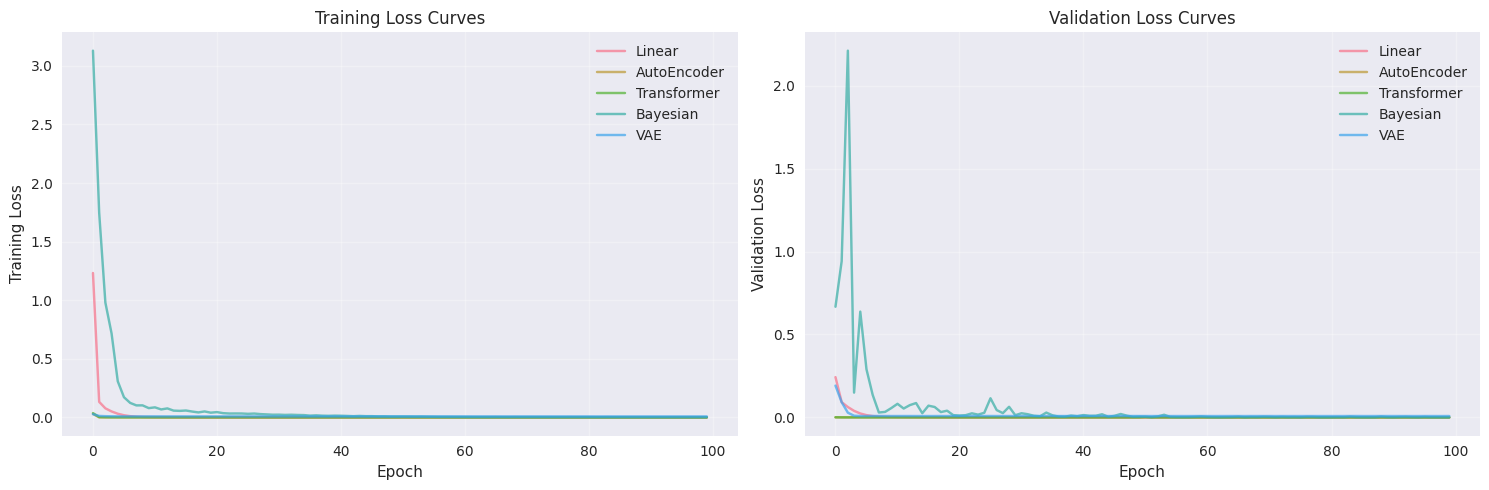


Final Loss Summary:
Algorithm       Train Loss      Val Loss        Train Time (s) 
------------------------------------------------------------
Linear          0.000098        0.000097        4.22           
AutoEncoder     0.000003        0.000001        8.86           
Transformer     0.000006        0.000003        22.35          
Bayesian        0.000734        0.000190        11.06          
VAE             0.008257        0.008284        11.77          


In [69]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for algo_name, results in all_results.items():
    epochs = range(len(results['train_losses']))
    axes[0].plot(epochs, results['train_losses'], label=algo_name, alpha=0.7)
    axes[1].plot(epochs, results['val_losses'], label=algo_name, alpha=0.7)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal Loss Summary:")
print(f"{'Algorithm':<15} {'Train Loss':<15} {'Val Loss':<15} {'Train Time (s)':<15}")
print("-" * 60)
for algo_name, results in all_results.items():
    print(f"{algo_name:<15} {results['train_losses'][-1]:<15.6f} {results['val_losses'][-1]:<15.6f} {results['train_time']:<15.2f}")

## Evaluate Trained Agents

Now test the trained agents in the environment.

In [ ]:
print("="*60)
print("EVALUATING ALL AGENTS")
print("="*60)

# Evaluation function (FIXED: state-only)
def evaluate_agent_simple(agent, env, num_episodes=50, max_steps=200):
    """Evaluate agent in environment using state-only."""
    results = {
        'rewards': [],
        'successes': [],
        'steps': []
    }
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        
        for step in range(max_steps):
            # Predict action using state only (goal is in state[4:6])
            state_t = torch.tensor(state, dtype=torch.float32, device=CONFIG['device'])
            action = agent.predict_action(state_t, None)  # No goal parameter
            
            # Convert to numpy if needed
            if isinstance(action, torch.Tensor):
                action = action.cpu().numpy()
            
            # Step environment
            next_state, reward, done, info = env.step(action)
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        results['rewards'].append(episode_reward)
        # Check if goal was reached
        success = info.get('reason', '') == 'goal_reached' if done else False
        results['successes'].append(1 if success else 0)
        results['steps'].append(step + 1)
    
    return {
        'avg_reward': np.mean(results['rewards']),
        'std_reward': np.std(results['rewards']),
        'success_rate': np.mean(results['successes']),
        'avg_steps': np.mean(results['steps'])
    }

# Evaluate each agent
eval_results = {}

for algo_name, results_dict in all_results.items():
    print(f"\nEvaluating {algo_name}...")
    agent = results_dict['agent']
    
    eval_res = evaluate_agent_simple(
        agent, env, 
        num_episodes=CONFIG['num_test_episodes'],
        max_steps=CONFIG['max_steps']
    )
    
    eval_results[algo_name] = eval_res
    
    print(f"  Avg Reward: {eval_res['avg_reward']:.3f} ± {eval_res['std_reward']:.3f}")
    print(f"  Success Rate: {eval_res['success_rate']:.1%}")
    print(f"  Avg Steps: {eval_res['avg_steps']:.1f}")

print(f"\n{'='*60}")
print("EVALUATION COMPLETE!")
print(f"{'='*60}")


EVALUATING ALL AGENTS

Evaluating Linear...
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success boolean False
success bo


FINAL RESULTS SUMMARY
  Algorithm  Train Loss     Val Loss  Train Time (s)  Avg Reward  Success Rate  Avg Steps
AutoEncoder    0.000003 5.654559e-07        8.856625  -60.574425           0.0      42.00
Transformer    0.000006 3.385327e-06       22.347961  -60.574463           0.0      42.00
     Linear    0.000098 9.709298e-05        4.216820  -60.572098           0.0      42.02
   Bayesian    0.000734 1.897554e-04       11.057444  -60.565697           0.0      42.20
        VAE    0.008257 8.283581e-03       11.769625  -60.328400           0.0      48.00


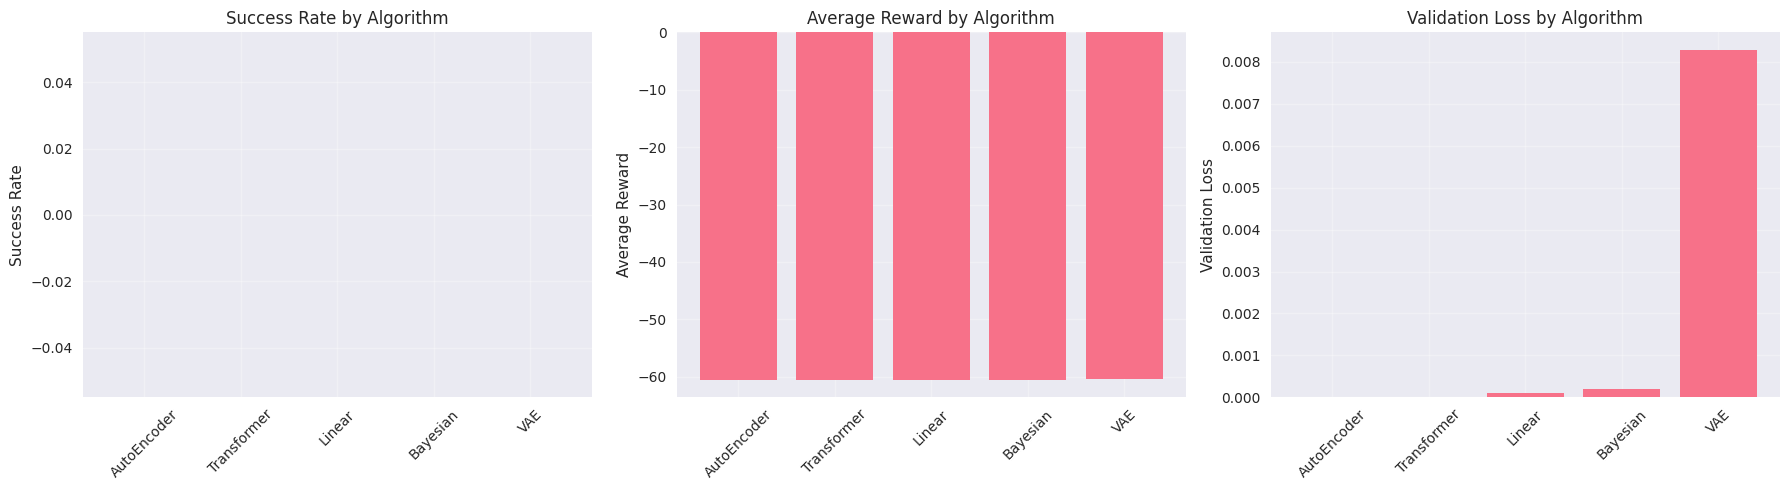

In [71]:
# Create comprehensive results table
import pandas as pd

results_data = []
for algo_name in all_results.keys():
    train_res = all_results[algo_name]
    eval_res = eval_results[algo_name]
    
    results_data.append({
        'Algorithm': algo_name,
        'Train Loss': train_res['train_losses'][-1],
        'Val Loss': train_res['val_losses'][-1],
        'Train Time (s)': train_res['train_time'],
        'Avg Reward': eval_res['avg_reward'],
        'Success Rate': eval_res['success_rate'],
        'Avg Steps': eval_res['avg_steps']
    })

df_results = pd.DataFrame(results_data)
df_results = df_results.sort_values('Val Loss')

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Success Rate
axes[0].bar(df_results['Algorithm'], df_results['Success Rate'])
axes[0].set_ylabel('Success Rate')
axes[0].set_title('Success Rate by Algorithm')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Average Reward
axes[1].bar(df_results['Algorithm'], df_results['Avg Reward'])
axes[1].set_ylabel('Average Reward')
axes[1].set_title('Average Reward by Algorithm')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Validation Loss
axes[2].bar(df_results['Algorithm'], df_results['Val Loss'])
axes[2].set_ylabel('Validation Loss')
axes[2].set_title('Validation Loss by Algorithm')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [72]:
print("="*60)
print("DEBUGGING: Action and State Analysis (FIXED: state-only)")
print("="*60)

# Test one agent on a single episode with detailed logging
agent = all_results['Linear']['agent']  # Use Linear for simplicity
state = env.reset()
goal = env.goal.copy()

print(f"\nInitial State: {state}")
print(f"  Position (x,y): {state[:2]}")
print(f"  Heading (theta): {state[2]:.3f}")
print(f"  Velocity: {state[3]:.3f}")
print(f"  Goal direction (dx,dy): {state[4:6]}")
print(f"  Obstacle direction (dx,dy): {state[6:8]}")
print(f"\nGoal Position: {goal}")
print(f"Initial Distance to Goal: {np.linalg.norm(state[:2] - goal):.3f}")
print(f"\nAction Space: [{env.action_space.low}, {env.action_space.high}]")

# Take 5 steps and inspect actions
print(f"\n{'Step':<6} {'Action':<20} {'State[:2]':<20} {'Distance':<10} {'Reward':<8}")
print("-" * 70)

for step in range(5):
    state_t = torch.tensor(state, dtype=torch.float32, device=CONFIG['device'])
    action = agent.predict_action(state_t, None)  # No goal parameter
    
    if isinstance(action, torch.Tensor):
        action = action.cpu().numpy()
    
    next_state, reward, done, info = env.step(action)
    distance = np.linalg.norm(next_state[:2] - goal)
    
    print(f"{step:<6} {str(action):<20} {str(next_state[:2]):<20} {distance:<10.3f} {reward:<8.3f}")
    
    state = next_state
    if done:
        print(f"\nEpisode ended: {info.get('reason', 'unknown')}")
        break

# Compare with training data actions
print(f"\n{'='*60}")
print("Training Data Action Statistics:")
print(f"{'='*60}")
print(f"Expert actions - Mean: {actions.mean(axis=0)}")
print(f"Expert actions - Std:  {actions.std(axis=0)}")
print(f"Expert actions - Min:  {actions.min(axis=0)}")
print(f"Expert actions - Max:  {actions.max(axis=0)}")

# Check model predictions vs expert on validation set
val_states_sample = val_states[:10]
val_actions_sample = val_actions[:10]

val_states_t = torch.tensor(val_states_sample, dtype=torch.float32, device=CONFIG['device'])
predictions = agent.predict_action(val_states_t, None)  # No goal parameter

if isinstance(predictions, torch.Tensor):
    predictions = predictions.cpu().numpy()

print(f"\nValidation Set Predictions vs Expert:")
print(f"{'Sample':<8} {'Predicted Action':<25} {'Expert Action':<25} {'Error':<10}")
print("-" * 70)
for i in range(5):
    pred = predictions[i]
    expert = val_actions_sample[i]
    error = np.linalg.norm(pred - expert)
    print(f"{i:<8} {str(pred):<25} {str(expert):<25} {error:<10.6f}")

print(f"\nAverage prediction error: {np.linalg.norm(predictions - val_actions_sample, axis=1).mean():.6f}")


DEBUGGING: Action and State Analysis (FIXED: state-only)

Initial State: [ 1.          1.          0.7853982   0.83920753  4.          4.
 -1.         -0.        ]
  Position (x,y): [1. 1.]
  Heading (theta): 0.785
  Velocity: 0.839
  Goal direction (dx,dy): [4. 4.]
  Obstacle direction (dx,dy): [-1. -0.]

Goal Position: [5. 5.]
Initial Distance to Goal: 5.657

Action Space: [[ 0.        -0.5235988], [2.        0.5235988]]

Step   Action               State[:2]            Distance   Reward  
----------------------------------------------------------------------
0      [0.7010844 0.5055556] [1.0495616 1.0548445] 5.583      0.020   
1      [0.69376963 0.49385843] [1.093479  1.1085513] 5.514      0.021   
2      [0.69293916 0.49249187] [1.13465   1.1642882] 5.446      0.021   
3      [0.6975828  0.49965408] [1.1732427 1.2223986] 5.377      0.021   
4      [0.7030971 0.5072372] [1.2091209 1.2828653] 5.309      0.021   

Training Data Action Statistics:
Expert actions - Mean: [0.8273852  0.